# Looking at the number of bits set by different fingerprints

I've done a number of posts looking at Morgan fingerprint statistics before, including:

  - [The number of collisions in Morgan fingerprints](https://rdkit.blogspot.ch/2014/02/colliding-bits.html). 
  - [Morgan fingerprint stats](https://rdkit.blogspot.ch/2016/02/morgan-fingerprint-bit-statistics.html)
  - [Collisions in Morgan fingerprints revisited](https://rdkit.blogspot.com/2016/02/colliding-bits-iii.html)

I have done similar analysis for other fingerprint types, but it looks like I didn't post that (at least I can't find it if I did). It's useful to do this because, as we'll see, the different fingerprint types have *very* different numbers of bits set for typical molecules.

Here's the summary of the mean and standard deviation of the number of bits set, from an analysis of 5 million molecules with less than 50 heavy atoms extracted from ZINC:

| Fingerprint | Type | Mean num_bits | SD num_bits |
|-------------|------|---------------|-------------|
| Morgan1 | sparse | 29.4 | 5.6 |
| Morgan2 | sparse | 	48.7 | 9.6 |
| Morgan3 | sparse | 	66.8 | 13.8 |
| FeatMorgan1 | sparse | 20.1 | 3.9 |
| FeatMorgan2 | sparse | 38.1 | 7.7 |
| FeatMorgan3 | sparse | 56.0 | 11.8 |
| RDKit5 | bitvect | 363 | 122 |
| RDKit6 | bitvect | 621 | 233 |
| RDKit7 | bitvect | 993 | 406 |
| pattern | bitvect | 446 | 122 |
| avalon | bitvect | 280 | 130 |
| atom pairs | sparse| 167 | 56 |
| TT | sparse | 33.4 | 9.8 |
| atom pairs | bitvect | 267 | 90 |
| TT | bitvect | 47.2 | 12.0 |

The bit vector fingerprints were all 4096 bits long.

In [1]:
from rdkit import Chem,DataStructs
import time,random,gzip,pickle,copy
import numpy as np
from collections import Counter,defaultdict
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit import rdBase
%pylab inline

print(rdBase.rdkitVersion)
import time
print(time.asctime())

Populating the interactive namespace from numpy and matplotlib
2021.09.2
Sat Nov 27 05:43:29 2021


/home/glandrum/miniconda3/envs/rdkit_blog/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
try:
    import ipyparallel as ipp
    rc = ipp.Client()
    dview = rc[:]
    dview.execute('from rdkit import Chem')
    dview.execute('from rdkit import Descriptors')
    dview.execute('from rdkit.Chem import rdMolDescriptors')
    dview.execute('from rdkit.Avalon import pyAvalonTools')
except:
    print("could not use ipyparallel")
    dview = None

For test data I'll use the same 16 million ZINC compounds I used in the [bit statistics post](https://rdkit.blogspot.ch/2016/02/morgan-fingerprint-bit-statistics.html).

In [3]:
filen='/scratch/RDKit_git/LocalData/Zinc/zinc_all_clean.pkl.gz'

Loop over the molecules, skip anything with more than 50 atoms, and build fingerprints for all the others.

The fingerprints I generate for this analysis are:
- Sparse Morgan with radii 1, 2, and 3
- Sparse FeatureMorgan with radii 1, 2, and 3
- RDKit BitVect with maxPath 5, 6, and 7
- Pattern BitVect
- Avalon BitVect
- Sparse Atom Pairs
- Sparse Topological Torsions
- Atom Pair BitVect
- Topological Torsion BitVect

All of the BitVect fingerprints are 4096 bits long

In [4]:
import copy

historyf = gzip.open('../data/fp_bit_counts.history.pkl.gz','wb+')

counts=defaultdict(Counter)
t1 = time.time()
with gzip.open(filen,'rb') as inf:
    i = 0
    ms = []
    while 1:
        try:
            m,nm = pickle.load(inf)
        except EOFError:
            break
        if not m or m.GetNumHeavyAtoms()>50: continue
        ms.append(m)
        i+=1
        if len(ms)>=10000:
            for v in 1,2,3:
                cnts = dview.map_sync(lambda x,v=v:len(rdMolDescriptors.GetMorganFingerprint(x,v).GetNonzeroElements()),
                                     ms)
                for obc in cnts:
                    counts[('Morgan',v)][obc]+=1
            for v in 1,2,3:
                cnts = dview.map_sync(lambda x,v=v:len(rdMolDescriptors.GetMorganFingerprint(x,v,useFeatures=True).GetNonzeroElements()),
                                     ms)
                for obc in cnts:
                    counts[('FeatMorgan',v)][obc]+=1
            for v in 5,6,7:
                cnts = dview.map_sync(lambda x,v=v:Chem.RDKFingerprint(x,maxPath=v,fpSize=4096).GetNumOnBits(),
                                      ms)
                for obc in cnts:
                    counts[('RDKit',v)][obc]+=1
            cnts = dview.map_sync(lambda x:Chem.PatternFingerprint(x,fpSize=4096).GetNumOnBits(),
                                  ms)
            for obc in cnts:
                counts[('pattern',-1)][obc]+=1
            cnts = dview.map_sync(lambda x:pyAvalonTools.GetAvalonFP(x,nBits=4096).GetNumOnBits(),
                                  ms)
            for obc in cnts:
                counts[('avalon',-1)][obc]+=1
            cnts = dview.map_sync(lambda x:len(rdMolDescriptors.GetAtomPairFingerprint(x).GetNonzeroElements()),
                                  ms)
            for obc in cnts:
                counts[('ap-counts',-1)][obc]+=1
            cnts = dview.map_sync(lambda x:len(rdMolDescriptors.GetTopologicalTorsionFingerprint(x).GetNonzeroElements()),
                                  ms)
            for obc in cnts:
                counts[('tt-counts',-1)][obc]+=1
            cnts = dview.map_sync(lambda x:rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(x,nBits=4096).GetNumOnBits(),
                                  ms)
            for obc in cnts:
                counts[('ap-bv',-1)][obc]+=1
            cnts = dview.map_sync(lambda x:rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(x,nBits=4096).GetNumOnBits(),
                                  ms)
            for obc in cnts:
                counts[('tt-bv',-1)][obc]+=1
            ms = []
            
        if not i%50000:
            t2 = time.time()
            print("Done %d in %.2f sec"%(i,t2-t1))
        if not i%500000:
            pickle.dump(dict(counts),historyf)
        if i>=5000000:
            break

Done 50000 in 38.37 sec
Done 100000 in 76.13 sec
Done 150000 in 112.82 sec
Done 200000 in 159.44 sec
Done 250000 in 209.28 sec
Done 300000 in 260.03 sec
Done 350000 in 309.92 sec
Done 400000 in 361.23 sec
Done 450000 in 401.80 sec
Done 500000 in 452.73 sec
Done 550000 in 508.33 sec
Done 600000 in 551.27 sec
Done 650000 in 601.37 sec
Done 700000 in 650.59 sec
Done 750000 in 699.14 sec
Done 800000 in 747.98 sec
Done 850000 in 793.70 sec
Done 900000 in 841.68 sec
Done 950000 in 888.89 sec
Done 1000000 in 934.87 sec
Done 1050000 in 981.82 sec
Done 1100000 in 1028.41 sec
Done 1150000 in 1074.17 sec
Done 1200000 in 1120.49 sec
Done 1250000 in 1165.59 sec
Done 1300000 in 1208.65 sec
Done 1350000 in 1256.99 sec
Done 1400000 in 1304.47 sec
Done 1450000 in 1349.63 sec
Done 1500000 in 1397.88 sec
Done 1550000 in 1442.67 sec
Done 1600000 in 1486.97 sec
Done 1650000 in 1531.26 sec
Done 1700000 in 1576.05 sec
Done 1750000 in 1629.38 sec
Done 1800000 in 1681.49 sec
Done 1850000 in 1738.35 sec
Done 19

In [5]:
pickle.dump(dict(counts),gzip.open('../data/fp_bit_counts.pkl.gz','wb+'))

Now plot the distributions of the number of bits set

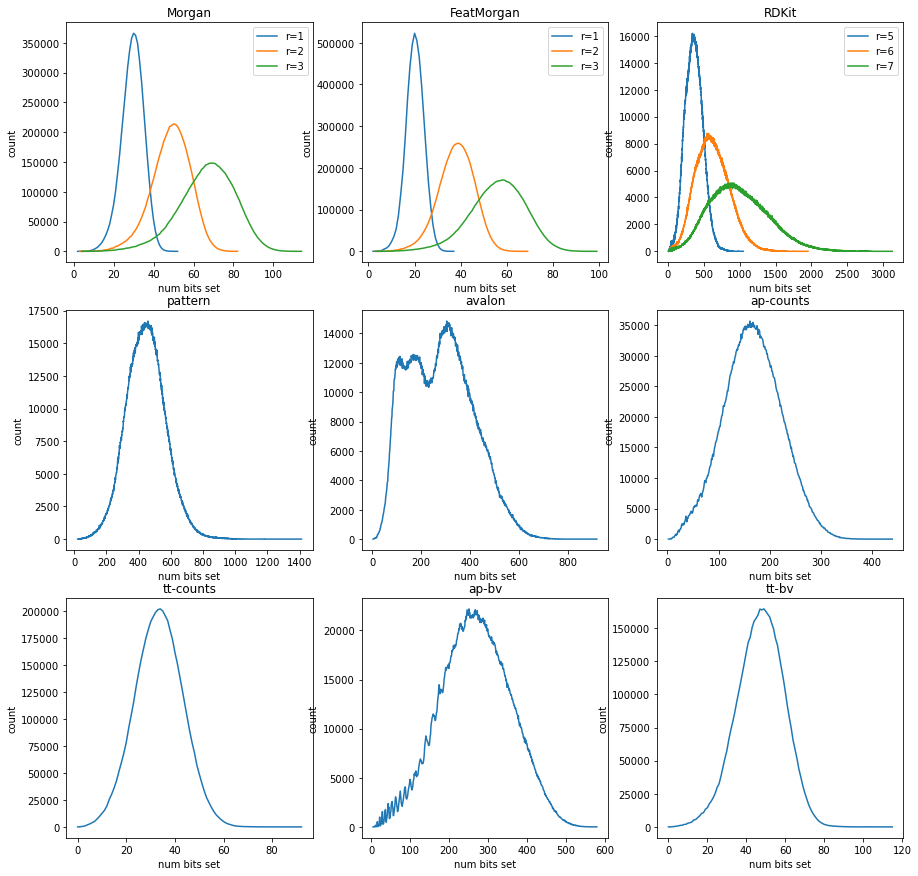

In [6]:
morgan_ks = [x for x in counts.keys() if x[0] =='Morgan']
featmorgan_ks = [x for x in counts.keys() if x[0] =='FeatMorgan']
rdkit_ks = [x for x in counts.keys() if x[0] == 'RDKit']

figure(figsize=(15,15))

pidx=1
subplot(3,3,pidx)
for n,r in morgan_ks:
    cnts = sorted(counts[(n,r)].items())
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("Morgan")
_=xlabel("num bits set")
_=ylabel("count")
_=legend()

pidx=2
subplot(3,3,pidx)
for n,r in featmorgan_ks:
    cnts = sorted(counts[(n,r)].items())
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("FeatMorgan")
_=xlabel("num bits set")
_=ylabel("count")
_=legend()

pidx=3
subplot(3,3,pidx)
for n,r in rdkit_ks:
    cnts = sorted(counts[(n,r)].items())
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("RDKit")
_=xlabel("num bits set")
_=ylabel("count")
_=legend()

for k in counts.keys():
    if k[0] in ('Morgan','FeatMorgan','RDKit'):
        continue
    pidx+=1
    subplot(3,3,pidx)
    cnts = sorted(counts[k].items())
    plot([x for x,y in cnts],[y for x,y in cnts])
    _=title(k[0])
    _=xlabel("num bits set")
    _=ylabel("count")
   


The avalon FP curve has an interesting shape

In [7]:
for k,cnts in counts.items():
    accum = 0
    denom = 0
    for cnt,num in cnts.items():
        accum += cnt*num
        denom += num
    mean = accum/denom
    dev = 0
    for cnt,num in cnts.items():
        dev += num*(cnt-mean)**2
    dev /= (denom-1)
    dev = dev**0.5
    label = k[0]
    if k[1]!=-1:
        label += str(k[1])
        
    print(label,'\t%.1f'%mean,'%.1f'%dev)

Morgan1 	29.4 5.6
Morgan2 	48.7 9.6
Morgan3 	66.8 13.8
FeatMorgan1 	20.1 3.9
FeatMorgan2 	38.1 7.7
FeatMorgan3 	56.0 11.8
RDKit5 	363.3 122.5
RDKit6 	621.7 233.2
RDKit7 	993.6 406.3
pattern 	445.5 122.5
avalon 	279.8 129.9
ap-counts 	166.6 56.3
tt-counts 	33.4 9.8
ap-bv 	267.3 90.0
tt-bv 	47.2 12.0


# Convergence

I did 5 million examples, which took a while (about 1.5 hours with 6 worker processes on my PC). Could I have analyzed less and gotten to the same results? Did the means converge? If so, how quickly?

In [8]:
historyf = gzip.open('../data/fp_bit_counts.history.pkl.gz','rb')
means = defaultdict(list)
devs = defaultdict(list)
nmols = []
while 1:
    try:
        lcounts = pickle.load(historyf)
    except EOFError:
        break
    for k,cnts in lcounts.items():
        accum = 0
        denom = 0
        for cnt,num in cnts.items():
            accum += cnt*num
            denom += num
        mean = accum/denom
        dev = 0
        for cnt,num in cnts.items():
            dev += num*(cnt-mean)**2
        dev /= (denom-1)
        dev = dev**0.5
        
        if denom not in nmols:
            nmols.append(denom)
        means[k].append(mean)
        devs[k].append(dev)
        label = k[0]
        if k[1]!=-1:
            label += str(k[1])

        print(denom,label,'\t%.1f'%mean,'%.1f'%dev)    

500000 Morgan1 	26.0 6.2
500000 Morgan2 	42.8 10.7
500000 Morgan3 	58.7 15.5
500000 FeatMorgan1 	18.2 4.3
500000 FeatMorgan2 	33.8 8.5
500000 FeatMorgan3 	49.5 13.2
500000 RDKit5 	324.6 133.9
500000 RDKit6 	560.8 256.2
500000 RDKit7 	902.9 445.7
500000 pattern 	408.8 133.9
500000 avalon 	241.8 133.8
500000 ap-counts 	133.3 57.6
500000 tt-counts 	28.6 10.2
500000 ap-bv 	219.5 93.6
500000 tt-bv 	41.9 12.9
1000000 Morgan1 	27.1 6.1
1000000 Morgan2 	44.6 10.5
1000000 Morgan3 	61.2 15.2
1000000 FeatMorgan1 	18.9 4.2
1000000 FeatMorgan2 	35.2 8.4
1000000 FeatMorgan3 	51.6 13.0
1000000 RDKit5 	340.7 133.9
1000000 RDKit6 	588.9 257.4
1000000 RDKit7 	948.5 449.9
1000000 pattern 	425.2 136.0
1000000 avalon 	257.7 136.7
1000000 ap-counts 	143.7 57.7
1000000 tt-counts 	30.1 10.1
1000000 ap-bv 	234.4 92.8
1000000 tt-bv 	43.6 12.9
1500000 Morgan1 	27.3 5.8
1500000 Morgan2 	45.0 9.9
1500000 Morgan3 	61.7 14.3
1500000 FeatMorgan1 	19.0 4.1
1500000 FeatMorgan2 	35.5 8.0
1500000 FeatMorgan3 	52.0 12.3
1

Let's look at those graphically:

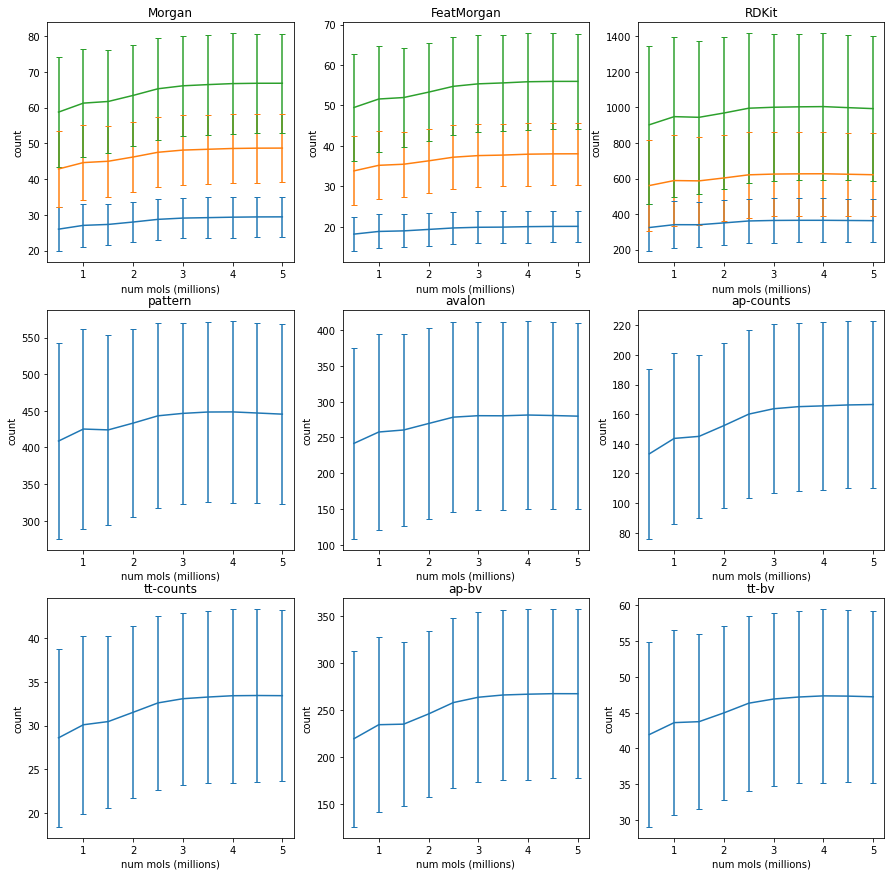

In [9]:
morgan_ks = [x for x in counts.keys() if x[0] =='Morgan']
featmorgan_ks = [x for x in counts.keys() if x[0] =='FeatMorgan']
rdkit_ks = [x for x in counts.keys() if x[0] == 'RDKit']

figure(figsize=(15,15))

nmols2 = [x/1000000 for x in nmols]

pidx=1
subplot(3,3,pidx)
for n,r in morgan_ks:
    lmeans = means[(n,r)]
    ldevs = devs[(n,r)]
    errorbar(nmols2,lmeans,yerr=ldevs,capsize=3)
    
_=title("Morgan")
_=xlabel("num mols (millions)")
_=ylabel("count")
#_=legend()

pidx=2
subplot(3,3,pidx)
for n,r in featmorgan_ks:
    lmeans = means[(n,r)]
    ldevs = devs[(n,r)]
    errorbar(nmols2,lmeans,yerr=ldevs,capsize=3)
_=title("FeatMorgan")
_=xlabel("num mols (millions)")
_=ylabel("count")
#_=legend()

pidx=3
subplot(3,3,pidx)
for n,r in rdkit_ks:
    lmeans = means[(n,r)]
    ldevs = devs[(n,r)]
    errorbar(nmols2,lmeans,yerr=ldevs,capsize=3)
_=title("RDKit")
_=xlabel("num mols (millions)")
_=ylabel("count")
#_=legend()

for k in counts.keys():
    if k[0] in ('Morgan','FeatMorgan','RDKit'):
        continue
    pidx+=1
    subplot(3,3,pidx)
    lmeans = means[k]
    ldevs = devs[k]
    errorbar(nmols2,lmeans,yerr=ldevs,capsize=3)
    _=title(k[0])
    _=xlabel("num mols (millions)")
    _=ylabel("count")
   


Looks like we would have been fine with 3 million molecules.